In [430]:
!pip install ipykernel matplotlib scikit-learn pandas numpy seaborn
!pip install xgboost

import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier

# List of csv files (datasets)
csv_files = ['matches-2023-2024.csv', 'matches-2022-2023.csv', 'matches-2021-2022.csv', 'matches-2020-2021.csv', 'matches-2019-2020.csv']

df_list = [pd.read_csv(file) for file in csv_files]
matches = pd.concat(df_list, ignore_index=True)
# matches = pd.read_csv('matches-2023-2024.csv')

df = matches.copy()

matches.tail()

,Date,Time,Home Team,XGH,Away Team,XGA,Score,FTHG,FTAG,Result,Referee
1895,2020-07-26,16:00,Manchester City,3.2,Norwich City,1.0,5–0,5,0,1,Craig Pawson
1896,2020-07-26,16:00,Chelsea,1.4,Wolves,0.2,2–0,2,0,1,Stuart Attwell
1897,2020-07-26,16:00,West Ham,0.9,Aston Villa,1.0,1–1,1,1,X,Michael Oliver
1898,2020-07-26,16:00,Newcastle Utd,0.1,Liverpool,0.6,1–3,1,3,2,Anthony Taylor
1899,2020-07-26,16:00,Burnley,1.7,Brighton,1.2,1–2,1,2,2,Jonathan Moss


In [431]:
# Convert Date to datetime
matches["Date"] = pd.to_datetime(matches["Date"])

In [432]:
# Create separate label encoders
home_encoder = LabelEncoder()
away_encoder = LabelEncoder()
referee_encoder = LabelEncoder()

df["Home Team"] = home_encoder.fit_transform(df["Home Team"])
df["Away Team"] = away_encoder.fit_transform(df["Away Team"])
df["Referee"] = referee_encoder.fit_transform(df["Referee"])

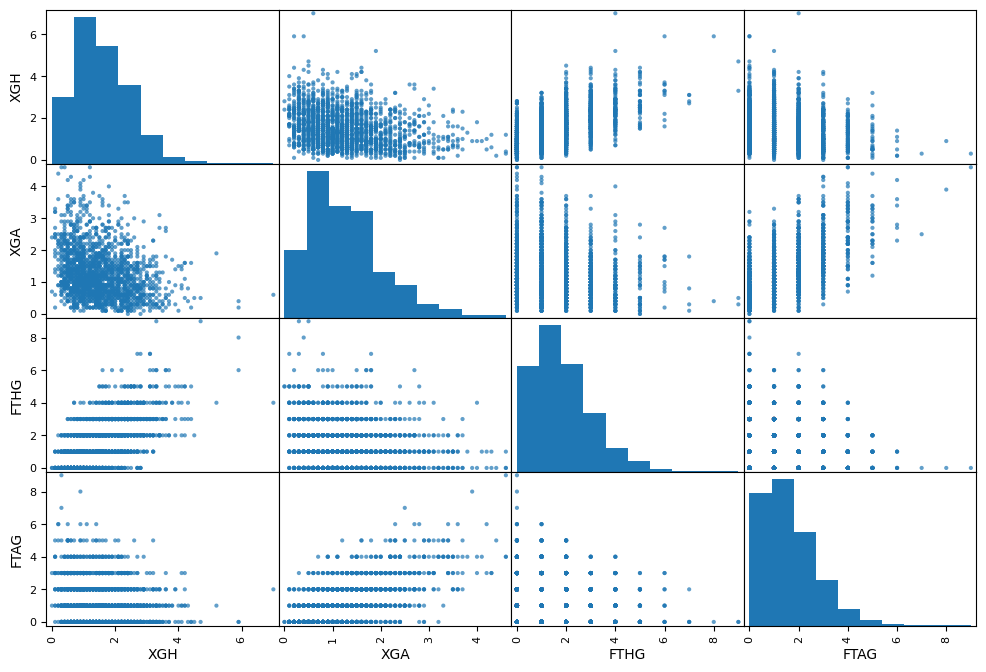

In [433]:
# Visualize data
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix

numerical_features = ["XGH", "XGA", "FTHG", "FTAG"]
scatter_matrix(df[numerical_features], figsize=(12, 8), alpha=0.7)
plt.show()

In [434]:
x = df[["XGH", "XGA", "FTHG", "FTAG", "Home Team", "Away Team", "Referee"]]
y = df["Result"]

result_encoder = LabelEncoder()
y_encoded = result_encoder.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(x, y_encoded, test_size=0.25, random_state=42)

# Ensure the columns are numeric
X_train[["XGH", "XGA", "FTHG", "FTAG"]] = X_train[["XGH", "XGA", "FTHG", "FTAG"]].astype('float64')
X_test[["XGH", "XGA", "FTHG", "FTAG"]] = X_test[["XGH", "XGA", "FTHG", "FTAG"]].astype('float64')

scaler = StandardScaler()

X_train.loc[:, ["XGH", "XGA", "FTHG", "FTAG"]] = scaler.fit_transform(X_train[["XGH", "XGA", "FTHG", "FTAG"]])
X_test.loc[:, ["XGH", "XGA", "FTHG", "FTAG"]] = scaler.transform(X_test[["XGH", "XGA", "FTHG", "FTAG"]])

# Train a Random Forest model
xgb_model = XGBClassifier(n_estimators=1000, learning_rate=0.005, colsample_bytree=0.5, subsample=0.8, max_depth=6, random_state=42)
xgb_model.fit(X_train, y_train)

y_pred = xgb_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Model Accuracy:", accuracy)

y_pred_decoded = result_encoder.inverse_transform(y_pred)

# Add Home Team and Away Team names to results_df
results_df = pd.DataFrame({
    'Home Team': df.loc[X_test.index, 'Home Team'],
    'Away Team': df.loc[X_test.index, 'Away Team'],
    'Result': result_encoder.inverse_transform(y_test),
    'Predicted': y_pred_decoded
})

# Decode team names back from numerical values
results_df["Home Team"] = home_encoder.inverse_transform(results_df["Home Team"])
results_df["Away Team"] = away_encoder.inverse_transform(results_df["Away Team"])

print(results_df.head(10))


Model Accuracy: 0.9852631578947368
           Home Team    Away Team Result Predicted
1222          Fulham      Everton      2         2
111          Arsenal      Burnley      1         1
554   Crystal Palace    Tottenham      2         2
526        Brentford    Tottenham      X         X
1310          Wolves    West Brom      2         2
1100        West Ham      Arsenal      2         2
70        Luton Town    Tottenham      2         2
251   Crystal Palace      Burnley      1         1
1314  Leicester City  Southampton      1         1
1029    Norwich City      Chelsea      2         2


In [435]:
# Feature Importance

importances = xgb_model.feature_importances_
feature_names = ["XGH", "XGA", "FTHG", "FTAG", "Home Team", "Away Team", "Referee"]
feature_importance_df = pd.DataFrame({"Feature": feature_names, "Importance": importances})
print(feature_importance_df.sort_values(by="Importance", ascending=False))

     Feature  Importance
2       FTHG    0.470258
3       FTAG    0.420156
1        XGA    0.031448
0        XGH    0.030470
4  Home Team    0.017359
5  Away Team    0.015504
6    Referee    0.014804


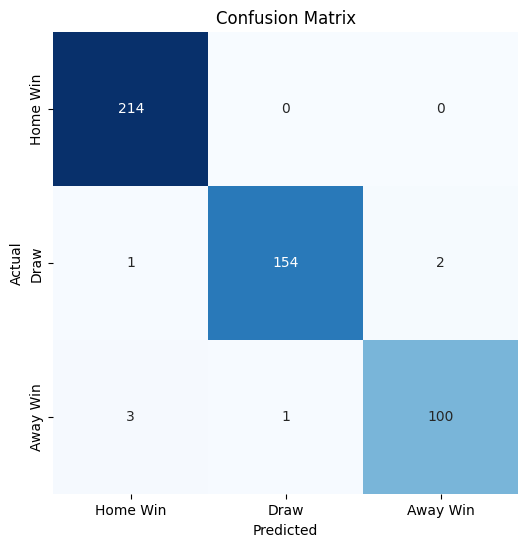

In [436]:
# Confusion Matrix

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Predict the results on the test set
y_pred = xgb_model.predict(X_test)

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix using Seaborn's heatmap
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, 
            xticklabels=['Home Win', 'Draw', 'Away Win'], 
            yticklabels=['Home Win', 'Draw', 'Away Win'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

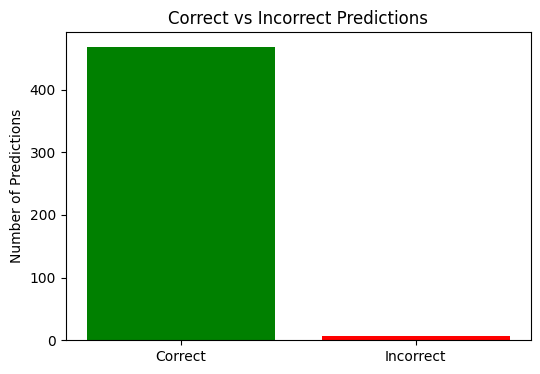

In [437]:
#Accuracy Plot

import numpy as np

# Calculate correct and incorrect predictions
correct_predictions = np.sum(y_pred == y_test)
incorrect_predictions = np.sum(y_pred != y_test)

# Plot the proportion of correct vs. incorrect predictions
plt.figure(figsize=(6, 4))
plt.bar(['Correct', 'Incorrect'], [correct_predictions, incorrect_predictions], color=['green', 'red'])
plt.title('Correct vs Incorrect Predictions')
plt.ylabel('Number of Predictions')
plt.show()

In [438]:
# Predict matches

new_matches = pd.DataFrame({
    'Home Team': ["Nott'ham Forest", 'Manchester Utd'],
    'Away Team': ['Manchester City', 'Arsenal'],
    'Referee': ["Anthony Taylor", "Anthony Taylor"],
    'XGH': [0.73, 1.52],
    'XGA': [0.86, 1.62],
    'FTHG': [0, 0],
    'FTAG': [0, 0]
})

# Encode categorical columns
new_matches["Home Team"] = home_encoder.transform(new_matches["Home Team"])
new_matches["Away Team"] = away_encoder.transform(new_matches["Away Team"])
new_matches["Referee"] = referee_encoder.transform(new_matches["Referee"])

new_matches[["XGH", "XGA", "FTHG", "FTAG"]] = scaler.transform(new_matches[["XGH", "XGA", "FTHG", "FTAG"]])

new_matches = new_matches[['XGH', 'XGA', 'FTHG', 'FTAG', 'Home Team', 'Away Team', 'Referee']]

predicted_results = xgb_model.predict(new_matches)

predicted_results_decoded = result_encoder.inverse_transform(predicted_results)

print(predicted_results_decoded)

['X' 'X']
